# 예측 애널리틱스: Random Forest 실습

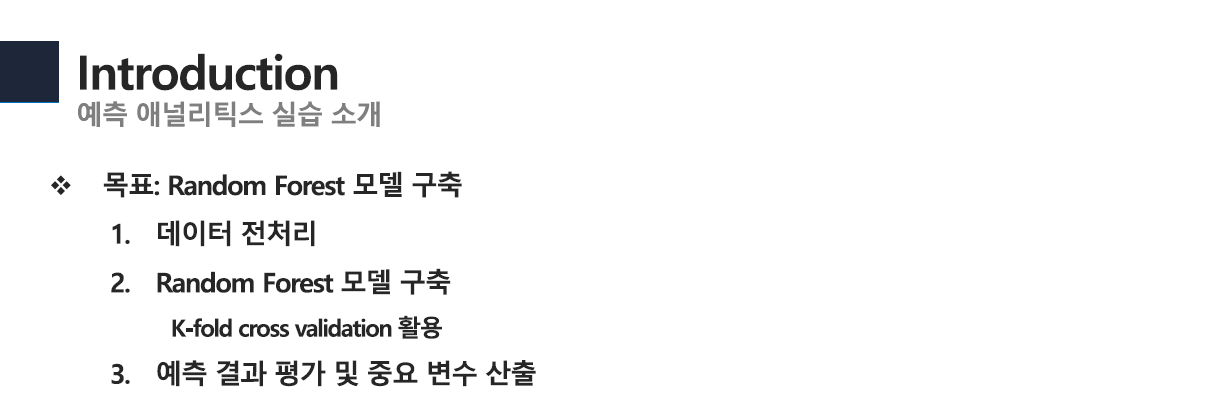

이지윤 / jiyoonlee@korea.ac.kr

## 1. 모듈 불러오기

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')

# 실습용 데이터 패키지
from sklearn.datasets import load_breast_cancer, load_boston

# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import KFold

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 2. 데이터 불러오기: Breast Cancer

#### 데이터 구조
- 데이터: 위스콘신 대학교에서 제공한 유방암 진단결과
- 관측치 개수: 569개
- 변수 개수: 32개 (ID, 진단결과, 30개의 실측변수 값)

#### 설명 변수(원인: 예측값을 설명할 수 있는 변수)      
- id: 환자 식별 번호
- radius: 반경 (중심에서 외벽까지 거리들의 평균값)
- texture: 질감(Gray-Scale값들의 표준편차)
- perimeter: 둘레
- area: 면적
- smoothness: 매끄러움(반경길이의 국소적 변화)
- compactness: 조그만 정도(둘레^2/면적-1)
- concavity: 오목함(윤곽의 오목한 부분의 정도)
- points: 오목한 점의 수
- symmetry: 대칭
- dimension: 프랙탈 차원(해안선 근사-1)
- mean: 3~12번 까지는 평균값을 의미
- se: 13~22번까지는 표준오차를 의미
- worst: 23~32는 각 세포별 구분들에서 제일 큰 3개의 값을 평균낸 값

#### 반응 변수(결과: 예측하고자 하는 값)
- diagnosis: 양성여부(Maligant=1 악성(유방암), Benign=0 양성(단순낭종))

In [ ]:
# 데이터셋 로드 및 설명 
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

In [ ]:
breast_cancer.data.shape

## 3. 탐색적 데이터 분석 및 데이터 전처리

$\mathbf{X}$: 독립변수, 예측변수, 입력변수 <br>
$\mathbf{y}$: 종속변수, 반응변수, 출력변수

In [ ]:
# 데이터 프레임 형태로 변환
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [ ]:
X.head()

In [ ]:
X.tail()

In [ ]:
y.tail()

### 결측치, 데이터 타입 확인

In [ ]:
X.info()

In [ ]:
X.describe()

In [ ]:
y['diagnosis'].value_counts()

### Train/Test 데이터 분리
- Training 데이터 70% / Testing 데이터 30% 나누기

In [ ]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=2021)

# 데이터 컬럼 단위 정규화 하기
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

## 4. 모델링
- 하이퍼파라미터 결정

### 4.1 단순 모델링 (사용자가 하이퍼 파라미터 정의)

In [ ]:
rfc = RandomForestClassifier(n_estimators=10,random_state=2021)
rfc.fit(X_train, y_train)

In [ ]:
# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

### 4.2 단일 하이퍼 파라미터에 대한 Grid search

In [ ]:
cv_scores = []
estimator_list =[i for i in range(0,50,1)]
for i in tqdm(range(0,50,1)):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 tree개수:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

In [ ]:
rfc = RandomForestClassifier(n_estimators=37, n_jobs=-1, random_state=2021)
rfc.fit(X_train, y_train)

# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

### 4.3 전체 하이퍼 파라미터에 대한 Grid search (파라미터 최적화)
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

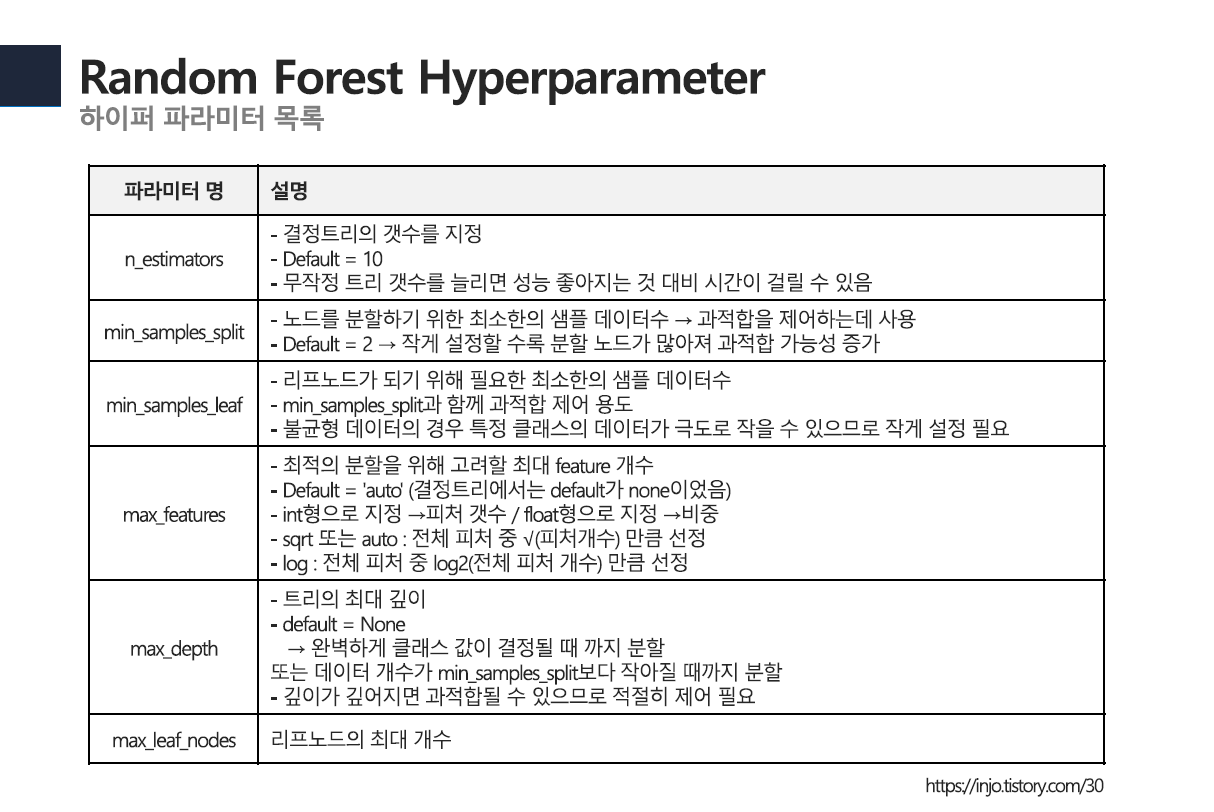

In [ ]:
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators': [50, 60, 70],
    'max_depth': [10,15,20],
    'max_leaf_nodes': [50, 100, 200],
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12)
CV_rfc.fit(X_train, y_train)

In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfc.best_params_

In [ ]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

In [ ]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

In [ ]:
# Train set에 대한 성능
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

In [ ]:
recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도


print(f"정확도:{acc:0.4f}",f"민감도:{recall:0.4f}",f"정밀도:{precision:0.4f}", sep='  |  ')  

In [ ]:
plot_confusion_matrix(best_rfc, X_test, y_test, cmap=plt.cm.Blues)
plt.show()  

In [ ]:
feats = {}
for feature, importance in zip(breast_cancer.feature_names, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### 4.4 타 알고리즘과의 비교

In [ ]:
# KNN
classifier = KNeighborsClassifier(n_neighbors = 5, p=2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도

print('KNN')
print(f"정확도:{acc:0.4f}",f"민감도:{recall:0.4f}",f"정밀도:{precision:0.4f}", sep='  |  ')  

In [ ]:
# Decision Tree
classifier = DecisionTreeClassifier(random_state=2021)
param_grid = {
    'max_depth': [10,15,20],
    'max_leaf_nodes': [50, 100, 200],
    'criterion':['gini', 'entropy']
}

CV_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12)
CV_classifier.fit(X_train, y_train)

best_classifier = CV_classifier.best_estimator_
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도

print('Decision Tree')
print(f"정확도:{acc:0.4f}",f"민감도:{recall:0.4f}",f"정밀도:{precision:0.4f}", sep='  |  ')  

KNN
 - 정확도:0.9766  |  민감도:0.9907  |  정밀도:0.9725
            
Decision Tree
 - 정확도:0.9532  |  민감도:0.9720  |  정밀도:0.9541

Random Forest (proposed)
 - 정확도:0.9825  |  민감도:0.9907  |  정밀도:0.9815

### Regression 예시

In [ ]:
boston = load_boston()

# 데이터 프레임 형태로 변환
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

# Random Forest Regressor
rfr = RandomForestRegressor(random_state=2021)
param_grid = {
    'max_depth': [10, 50, 100, 200],
    'max_leaf_nodes': [50, 100, 200],
    'criterion':['mae', 'mse']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12, scoring='r2')
CV_rfr.fit(X_train, y_train)

best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

y_pred = best_rfr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)

print('Random Forest Regressor')
print(f"R2 score:{r2score:0.4f}",f"MSE:{mse:0.4f}",f"MAE:{mae:0.4f}", sep='  |  ')  

In [ ]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=2021)
param_grid = {
    'max_depth': [10, 50, 100, 200],
    'max_leaf_nodes': [50, 100, 200],
    'criterion':['mae', 'mse']
}

CV_dtr = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12, scoring='r2')
CV_dtr.fit(X_train, y_train)

best_dtr = CV_dtr.best_estimator_
best_dtr.fit(X_train, y_train)

y_pred = best_dtr.predict(X_test)


r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)

print('Decision Tree Regressor')
print(f"R2 score:{r2score:0.4f}",f"MSE:{mse:0.4f}",f"MAE:{mae:0.4f}", sep='  |  ')  

### EOD